In [3]:
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

# Getting the dataset
In this block, the full Cats-v-Dogs dataset will be downloaded and stored in a zip file. Next, the data is unzipped and stored in two directories, one for cat images and one for dog images.

In [4]:
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2020-12-23 12:39:47--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.195.64.241, 2600:1408:8c00:78e::e59, 2600:1408:8c00:787::e59
Connecting to download.microsoft.com (download.microsoft.com)|23.195.64.241|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M  83.6MB/s    in 11s     

2020-12-23 12:39:58 (72.1 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



In [5]:
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))

12501
12501


# Splitting the dataset into Training and Testing datatsets
Next, the dataset is split into two smaller datasets for training and testing.

In [6]:
#creating directories for training and testing using os.mkdir()
try:
    os.mkdir('/tmp/cats-v-dogs')
    os.mkdir('/tmp/cats-v-dogs/training')
    os.mkdir('/tmp/cats-v-dogs/testing')
    os.mkdir('/tmp/cats-v-dogs/training/cats')
    os.mkdir('/tmp/cats-v-dogs/training/dogs')
    os.mkdir('/tmp/cats-v-dogs/testing/cats')
    os.mkdir('/tmp/cats-v-dogs/testing/dogs')
except OSError:
    pass

In [7]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    
    for file_name in os.listdir(SOURCE):
        file_path = SOURCE + file_name

        if os.path.getsize(file_path):
            files.append(file_name)
        else:
            print('{} is zero length and hence being ignored.'.format(file_name))
    
    n_files = len(files)
    split_point = int(n_files * SPLIT_SIZE)
    
    shuffled_files = random.sample(files, n_files)
    
    train_set = shuffled_files[:split_point]
    test_set = shuffled_files[split_point:]
    
    for file_name in train_set:
        copyfile(SOURCE + file_name, TRAINING + file_name)
        
    for file_name in test_set:
        copyfile(SOURCE + file_name, TESTING + file_name)

CAT_SOURCE_DIR = r"/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = r"/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = r"/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = r"/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = r"/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = r"/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

666.jpg is zero length and hence being ignored.
11702.jpg is zero length and hence being ignored.


In [8]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

11250
11250
1250
1250


#Defining the model
A keras model is defined and initialised to classify the images. It uses 3 Convolution layers

In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150,150,3)),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=RMSprop(lr=0.0001), loss='binary_crossentropy', metrics=['acc'])

In [10]:
TRAINING_DIR = '/tmp/cats-v-dogs/training'

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    batch_size=20,
    class_mode='binary',
    target_size=(150,150)
)

VALIDATION_DIR = '/tmp/cats-v-dogs/testing'

validation_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'    
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    batch_size=20,
    class_mode='binary',
    target_size=(150,150)
)

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [11]:
import warnings
warnings.filterwarnings('ignore')
print('warnings ignored.')

warnings ignored.


# Training the Model

In [ ]:
history = model.fit(
      train_generator,
      epochs=50,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=8)

Epoch 1/50
1125/1125 [==============================] - 162s 144ms/step - loss: 0.6644 - acc: 0.5793 - val_loss: 0.6045 - val_acc: 0.6562
Epoch 2/50
1125/1125 [==============================] - 161s 143ms/step - loss: 0.5900 - acc: 0.6804 - val_loss: 0.5306 - val_acc: 0.7812
Epoch 3/50
1125/1125 [==============================] - 161s 143ms/step - loss: 0.5617 - acc: 0.7158 - val_loss: 0.5130 - val_acc: 0.7688
Epoch 4/50
 320/1125 [=======>......................] - ETA: 1:54 - loss: 0.5438 - acc: 0.7254

# Plotting Loss and Accuracy 

No handles with labels found to put in legend.


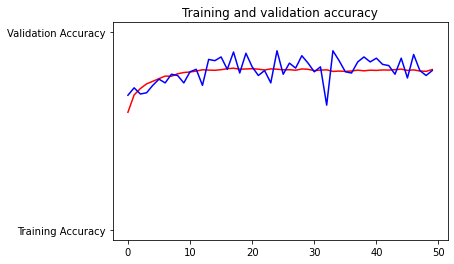

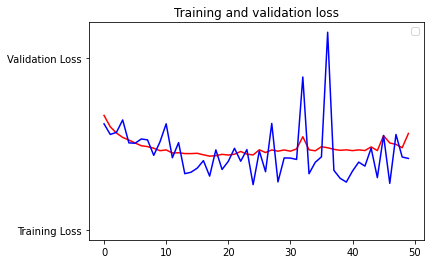

In [ ]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

# training and validation accuracy per epoch
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

# training and validation loss per epoch
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Add images to test the model

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
    # predicting images
    path = '/content/' + fn
    img = image.load_img(path, target_size=(150, 150))
    
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    print(classes[0])
    if classes[0]>0.5:
        print(fn + " is a dog")
    else:
        print(fn + " is a cat")

Saving bed-1284238_1920.jpg to bed-1284238_1920.jpg
[1.]
bed-1284238_1920.jpg is a dog
